
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>


# Tree Bagging vs Random Forest
## Does tree decorrelation actually improve prediction accuracy?

Jose E Ubillus Alcivar


#### Hildebrand Department of Petroleum and Geosystems Engineering,  Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin


### Executive Summary

Investigate whether tree decorrelation improve prediction accuracy. First, I run exploratory data analysis to check four outliers, data statistics and distribution. To achieve our goal is was necessary to create sparsity in the data by removing data samples, after this step. I trained and tuned a Rate of Penetration (ROP) regression model with tree bagging and random forest to compare their predictions and determine if the accuracy of the model improve. Random forest is a bit better but it is not reliable to say that it is a better model for this case scenario. I would always recommend to do a model comparison, because machine learning is not just about the model it is also about the data. 


### Import Packages

In [1]:
import pandas as pd        # used for data manipulation 
import numpy as np         # used for array manipulation
import matplotlib.pyplot as plt    # used to build plots
import seaborn as sns              # used to build plots

from sklearn.model_selection import train_test_split  # used to split the data in training and testing
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor   # used to build both models
from sklearn.tree import DecisionTreeRegressor     # decision tree model 
from sklearn.metrics import mean_squared_error, r2_score     # used to measure the accuracy of the model
from sklearn.model_selection import GridSearchCV

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

### Fonts and Figure Sizes

In [2]:
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [6,3]
plt.rcParams['figure.dpi'] = 100

### Functions

The following functions will be used in the workflow.


In [3]:
def true_estimated_comparison_plot(y_test,y_bag_pred,y_rf_pred): 
    
    '''Plot true vs estimated response feature using two models'''

    fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))

    ax1.scatter(y_test,y_bag_pred,color='blue',label='Tree Bagging')
    ax1.axline([0, 0], [1, 1],color='red',linestyle='--')
    ax1.set_title('True ROP vs Estimate ROP',pad=15)
    ax1.set_xlabel('True ROP ft/hr')
    ax1.set_ylabel('Estimate ROP ft/hr')
    ax1.set_xlim(0,200)
    ax1.set_ylim(0,200)
    ax1.legend()

    ax2.scatter(y_test,y_rf_pred,color='yellow',label='Random Forest')
    ax2.axline([0, 0], [1, 1],color='red',linestyle='--')
    ax2.set_title('True ROP vs Estimate ROP',pad=15)
    ax2.set_xlabel('True ROP ft/hr')
    ax2.set_ylabel('Estimate ROP ft/hr')
    ax2.set_xlim(0,200)
    ax2.set_ylim(0,200)
    ax2.legend()
    
    fig.tight_layout()
    return plt.show()

def model_training(X_train,y_train,X_test,y_test,min_samples_leaf,min_samples_leaf_rf,num_trees,num_trees_rf,max_features_rf):
    
    '''This function helps with model training using tree bagging and random forest'''
    
    # Tree bagging  
    bag=RandomForestRegressor(min_samples_leaf=min_samples_leaf,max_features=None,n_estimators=num_trees,random_state=13)
    bag.fit(X_train,y_train)

    y_bag_pred=bag.predict(X_test)
    mean_bag_error=mean_squared_error(y_test,y_bag_pred,multioutput='uniform_average')


    # Random Forest
    random_forest = RandomForestRegressor(n_estimators=num_trees_rf,max_features=max_features_rf,min_samples_leaf=min_samples_leaf_rf,random_state=13)
    random_forest.fit(X_train,y_train)

    y_rf_pred=random_forest.predict(X_test)
    mean_rf_error=mean_squared_error(y_test,y_rf_pred,multioutput='uniform_average')
    
    print(f'The MSE using Tree bagging is {round(mean_bag_error,3)}')
    print(f'The MSE using Random Forest is {round(mean_rf_error,3)}')

    return y_bag_pred, y_rf_pred

def hyperparameter_tuning(X_train,y_train,tb_grid,rf_grid):
    
    ''' This function will help us to tune our hyperparameters using the function Randomized Search CV'''

    # Create the model to be tuned
    random_forest = RandomForestRegressor()
    
    # Create the model to be tuned
    tree_bagging = RandomForestRegressor()

    # Create the random search Random Forest
    rf_rs = GridSearchCV(estimator = random_forest, param_grid = rf_grid,
                         cv = 5, verbose = 2, 
                               n_jobs = -1)
    
    # Create the random search Random Forest
    tb_rs = GridSearchCV(estimator = tree_bagging, param_grid = tb_grid,
                         cv = 5, verbose = 2, 
                               n_jobs = -1)
    
    # Fit the random search model
    rf_rs.fit(X_train, y_train)

    # Fit the random search model
    tb_rs.fit(X_train, y_train)

    print(f'The best hyperparameters for Random forest are:{rf_rs.best_params_}')
    print(f'The best hyperparameters for Tree Bagging are:{tb_rs.best_params_}')

    return 

### Load Data

The following workflow uses the .csv file 'ml_data.csv', data extracted from an oilfield in Ecuador. The dataset is publically available [here](https://github.com/pizzio98/PGE_383_FINAL_PROJECT/blob/main/ml_data.csv)  

We will work with the following features:

* **Weight on bit (prom_wob)** - amount of downward force exerted on the drill bit in thousand of pounds
* **Rotational speed (prom_rpm)** - number of rotations of a tool per unit of time in revolutions per minute
* **Flow rate (prom_q)** - volume of fluid that moves through a given cross-sectional area per unit of time in gallons per minute
* **Torque (prom_tq)** -  rotational force between the drill string and the formation in ft-lb
* **Max Pressure (p_ma_psi)** - maximum pressure measured in the drilling fluid pumps in psi
* **Rate of Penetration (rop_pph)** -  is the speed at which a drill bit breaks the rock under it to deepen the borehole in ft/hr

In [4]:
# Import the data from Github 
data=pd.read_csv(r'https://raw.githubusercontent.com/pizzio98/PGE_383_FINAL_PROJECT/main/ml_data.csv',index_col=0)
data

,"t, hr","md, ft",prom_wob,prom_rpm,prom_q,prom_tq,p_ma_psi,rop_pph
0,8.0,469,11.0,55.0,265.0,2.0,300,54.0
1,10.0,1107,17.5,75.0,480.0,2.0,500,63.0
2,1.5,1107,10.0,60.0,480.0,9.5,800,46.0
3,1.5,1273,12.5,60.0,480.0,6.5,900,65.0
4,3.5,1467,10.0,60.0,480.0,6.5,900,55.0
...,...,...,...,...,...,...,...,...
928,24.0,10445,19.0,65.0,415.0,17.0,2900,36.0
929,24.0,10445,11.0,0.0,450.0,0.0,2600,36.0
930,24.0,11015,14.0,65.0,450.0,21.0,2900,24.0
931,24.0,11015,11.0,0.0,450.0,0.0,2600,24.0


Let's create some sparsity in the data to better test our hypothesis

In [5]:
np.random.seed(13)
remove_n=733
drop_indices = np.random.choice(data.index,remove_n,replace=False)
data=data.drop(drop_indices).reset_index().drop(columns='index')
data

,"t, hr","md, ft",prom_wob,prom_rpm,prom_q,prom_tq,p_ma_psi,rop_pph
0,10.0,1107,17.5,75.0,480.0,2.0,500,63.0
1,3.5,2434,10.0,70.0,480.0,7.5,1100,55.0
2,3.5,2820,12.0,65.0,480.0,10.0,1200,55.0
3,6.5,2462,11.0,50.0,480.0,4.5,950,65.0
4,4.5,192,7.0,55.0,148.0,3.5,35,21.0
...,...,...,...,...,...,...,...,...
195,14.5,9965,21.0,70.0,400.0,20.0,2400,50.0
196,5.5,9580,14.0,0.0,550.0,0.0,3150,35.0
197,24.0,10445,19.0,65.0,415.0,17.0,2900,36.0
198,24.0,10445,11.0,0.0,450.0,0.0,2600,36.0


Let's drop variables that are not useful to predict ROP and check the summary statistics of the data

In [6]:
# Lets drop variables that are not useful to predict ROP 
data.drop(columns=['t, hr','md, ft'],inplace=True)

# lets check the summary statistics
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
prom_wob,200.0,17.0075,7.159959,2.0,12.000,17.00,21.00,37.5
prom_rpm,200.0,48.9625,31.263467,0.0,40.000,60.00,72.50,130.0
prom_q,200.0,688.8525,233.442066,50.0,480.000,740.00,880.00,1000.0
prom_tq,200.0,10.6000,7.929495,0.0,1.875,12.25,17.50,24.0
p_ma_psi,200.0,2886.0000,1556.653494,35.0,2200.000,3000.00,3750.00,19850.0
rop_pph,200.0,56.9830,35.923706,6.0,27.150,48.25,85.25,194.0


Let's check the distribution of the data to check for outliers, missing values or extra insights

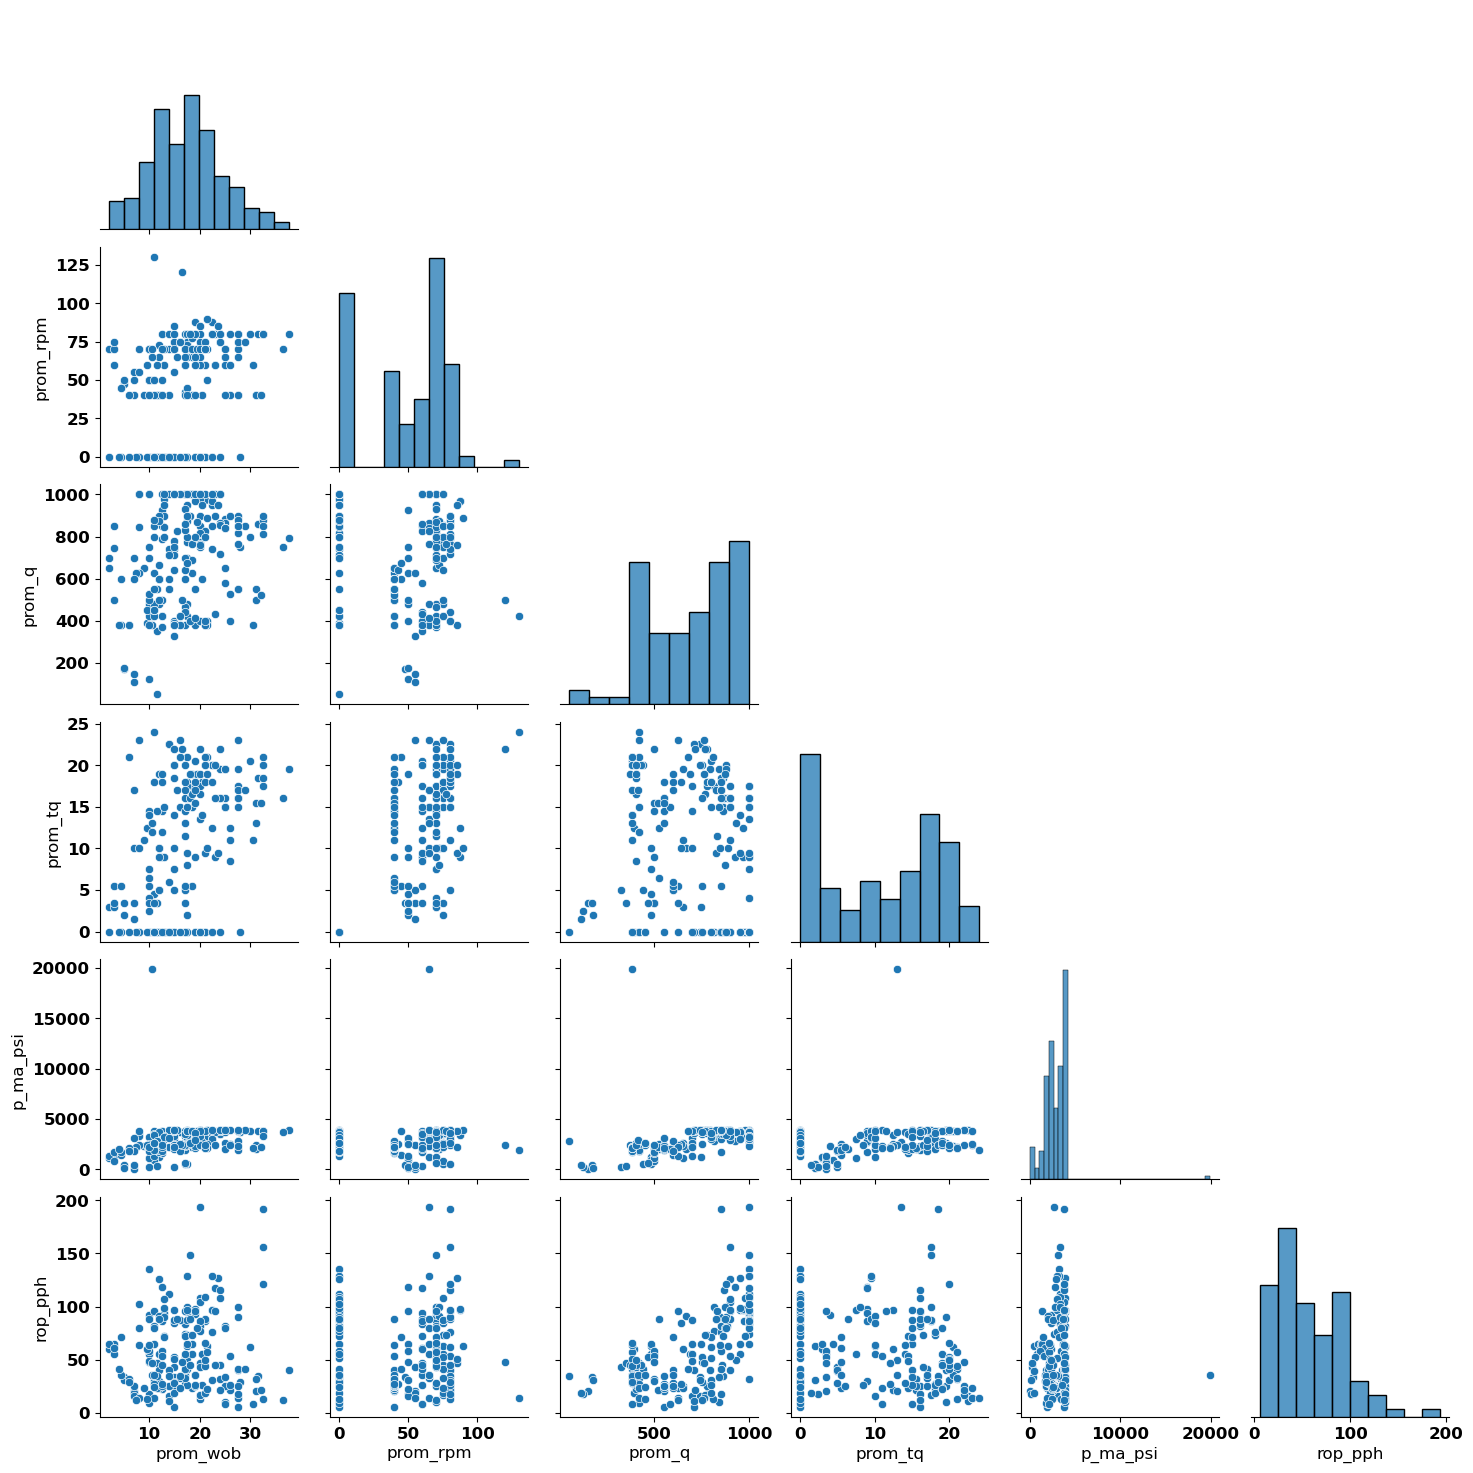

In [7]:
sns.pairplot(data,palette='YlGnBu',corner=True)
plt.show()

From the distribution above, we can infer the following:
* The data has been filled with missing values, which is okay because it is a valid feature imputation method
* There are some remarked outliers in flow rate and pressure which we can easily drop

The following lines of code are part of Professor Michael Pyrcz workflows from Subsurface Machine Learning course

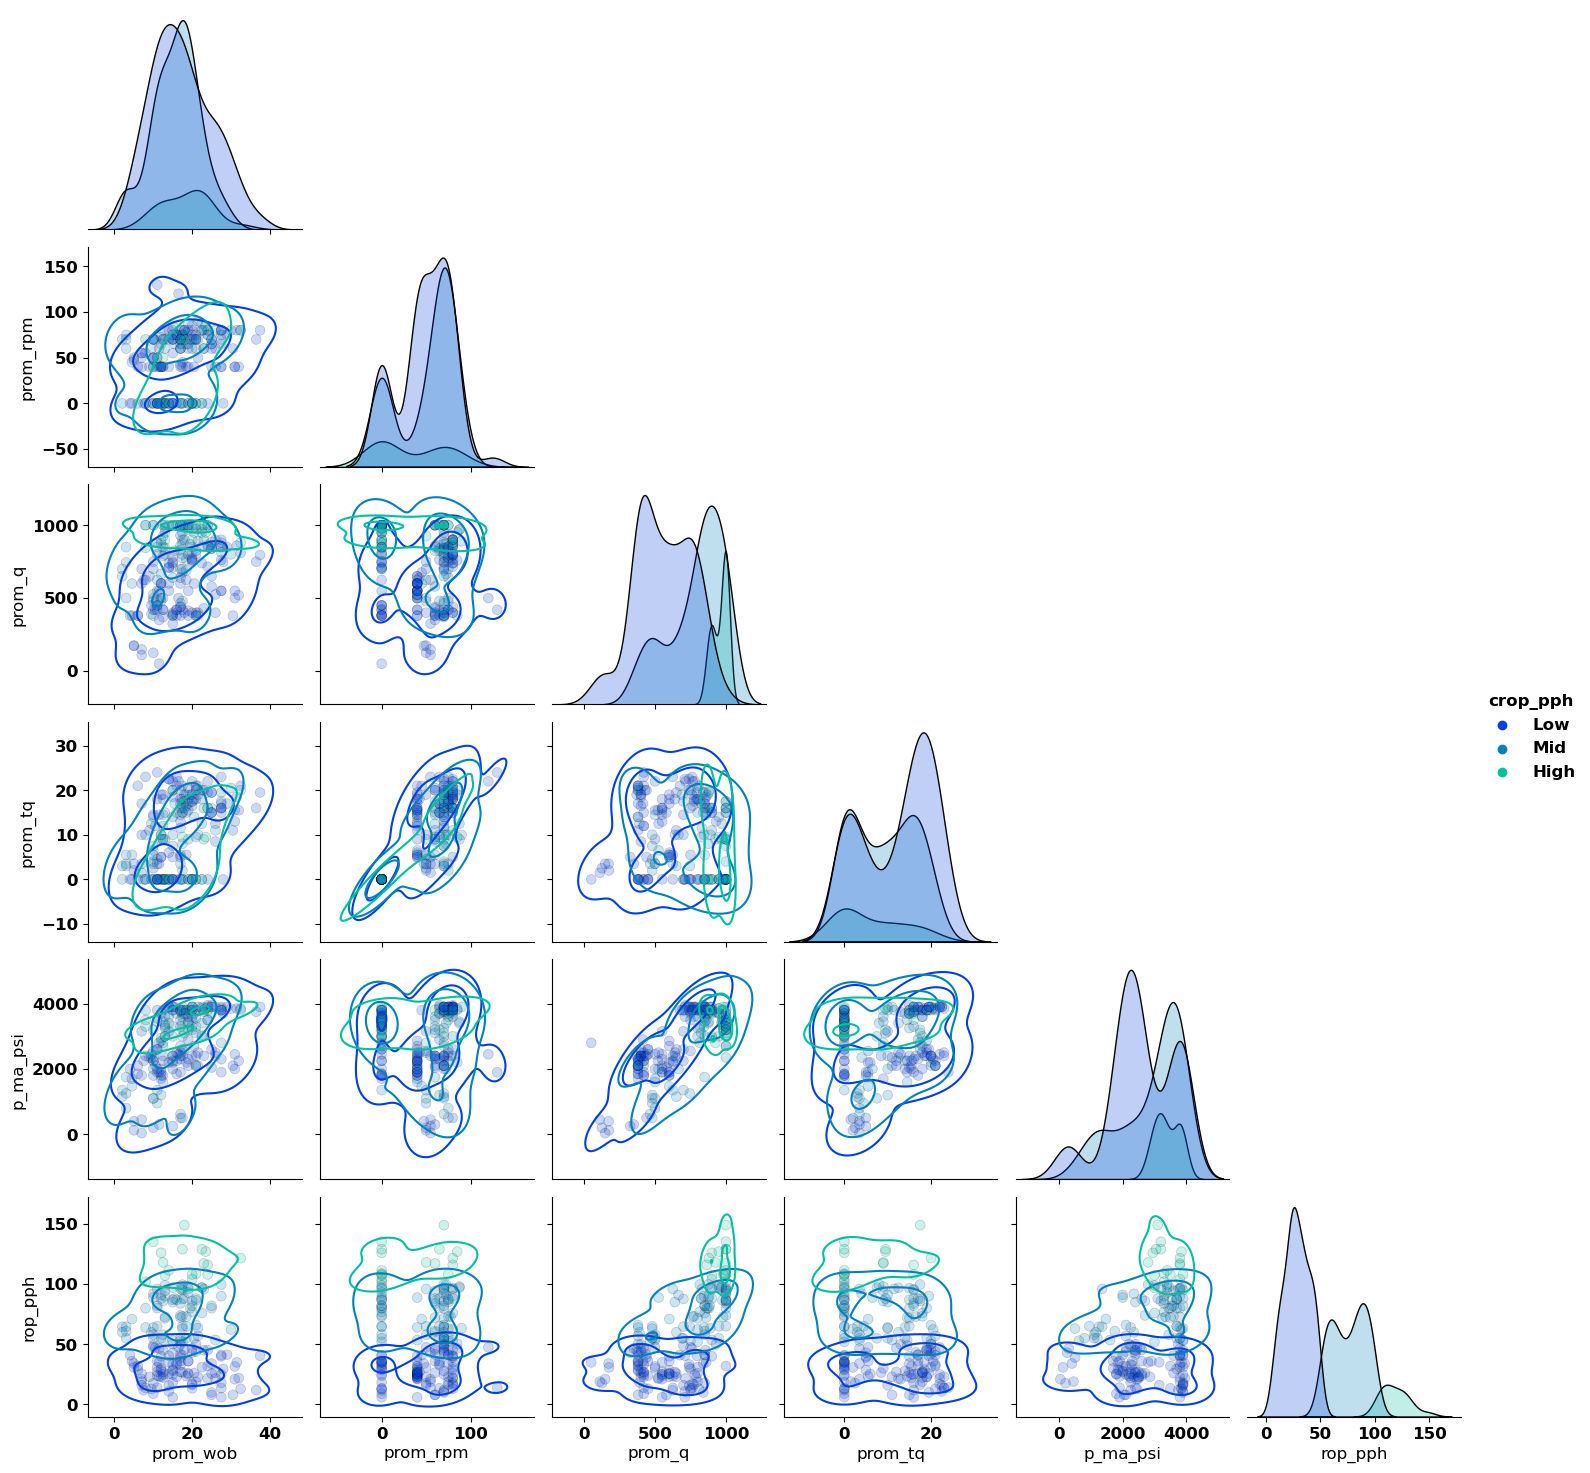

In [8]:
# Let's drop some remarked outliers in the data
data.drop(data[data.prom_q > 2500].index, inplace=True)
data.drop(data[data.p_ma_psi>10000].index,inplace=True)
data.drop(data[data.rop_pph==0].index,inplace=True)

#Bivariate distributions 

data['c' + data['rop_pph'].name] = pd.cut(x=data['rop_pph'], bins=[0, 50, 100, 150], # make a truncated response cateogorical feature
                     labels=['Low', 'Mid', 'High'])

nsample = len(data)                                       # set to less than number of samples for a speed up

dpalette = sns.color_palette("winter",n_colors = 3)   # matrix scatter plot with points and density estimator
palette = sns.color_palette("winter")

matrixplot = sns.pairplot(data.sample(n=nsample),hue ='c'+data['rop_pph'].name,diag_kind = 'kde',corner=True,palette = dpalette,diag_kws={'edgecolor':'black'},plot_kws=dict(s=50, edgecolor="black", linewidth=0.5,alpha=0.2))
matrixplot.map_lower(sns.kdeplot, levels=3, color="black")

plt.show()

Let's check the correlation matrix of our predictor features

The above code was extracted from Professor Michael Pyrcz workflows from Subsurface Machine Learning course

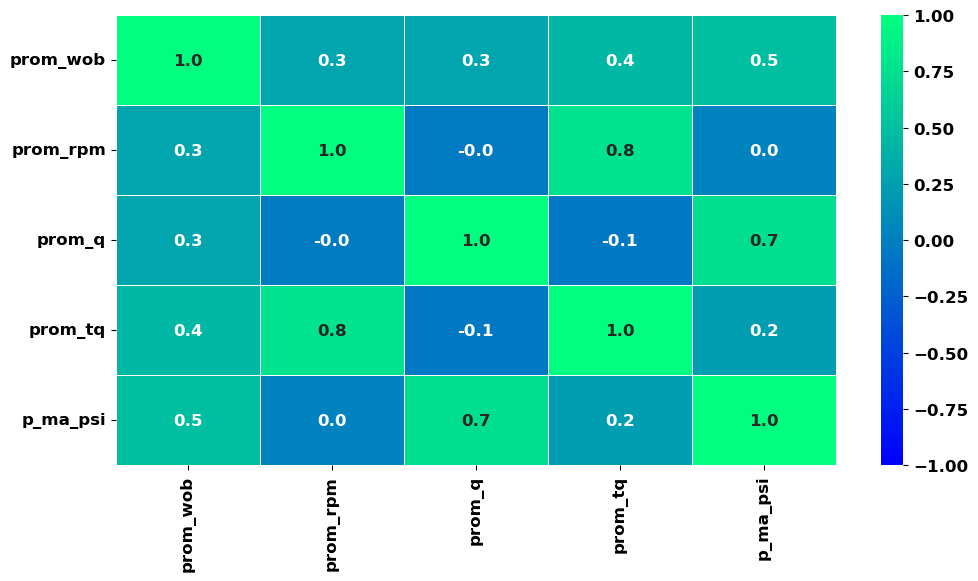

In [9]:
plt.subplot(111)                                        # plot correlation matrix with significance colormap
sns.heatmap(data.iloc[:,0:5].corr(),vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',annot=True,cmap='winter')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

It is time to build our machine learning models, we will perform the following steps:
* Train and test split
* Tree bagging and random forest model build
* Hyperparameter tuning
* Test our hypothesis

### Train and test split

In [10]:
np.random.seed(13)   # Set random seed to get same results

# Lets start building our machine learning model, lets split the data into training and testing
X=data.iloc[:,0:5]
y=data.iloc[:,-2]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=13)

### Tree bagging and random forest model
In the following step, we are going to build the models

In [11]:
# Lets train our model and get some preliminary results
min_samples_leaf=10
num_trees=10

num_trees_rf=10
min_samples_leaf_rf=10
max_features_rf=3

y_bag_pred,y_rf_pred=model_training(X_train,y_train,X_test,y_test,min_samples_leaf,min_samples_leaf_rf,num_trees,num_trees_rf,max_features_rf)

The MSE using Tree bagging is 514.114
The MSE using Random Forest is 530.344


Let's plot the true value vs the predicted value to observe the accuracy of our first trained model

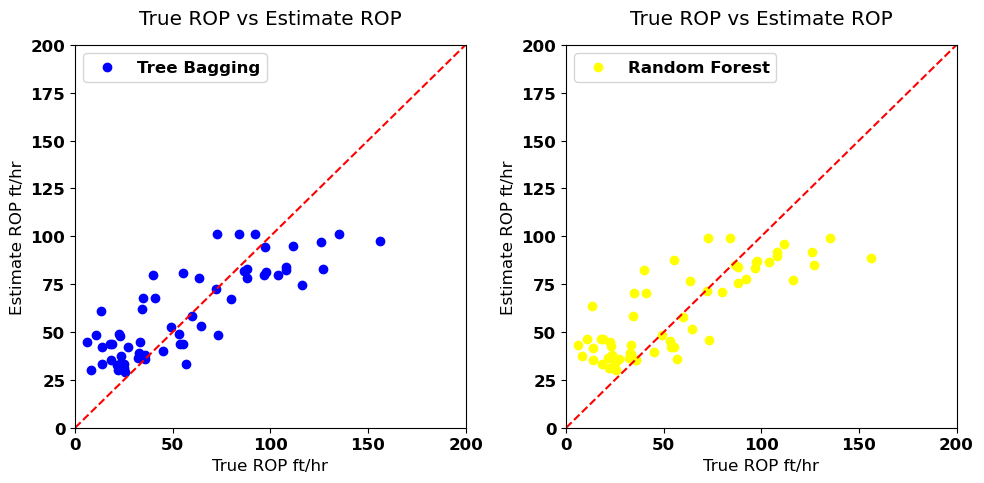

In [12]:
#Lets plot the estimation vs the predict value 
true_estimated_comparison_plot(y_test,y_bag_pred,y_rf_pred)

### Hyperparameter tuning

Let's make our trees big enough (no max depth tuning), instead we will tune minimum samples to split a node (min_samples_leaf) and the number of trees created(n_estimators)



This approach is tuning each hyperparameter separately and testing with the Out of Bag data but we can use GridSearchCV or RandomizedCV for hyperparameter tuning

Let's start by tuning the number of trees

Complete of 100:  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,  100,  

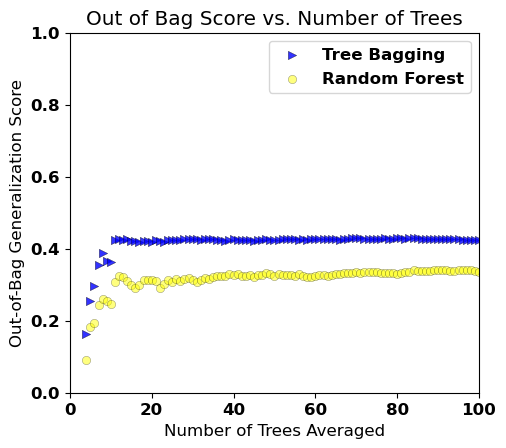

In [13]:
min_samples_leaf=20
num_trees= np.linspace(1,100,100)
max_features= 2

fit_bag=[]
oob_mse_bag=[]

fit_forest=[]
oob_mse_forest=[]

# The code below is extracted from Professor Michael Pyrcz workflows 

index = 1
print('Complete of ' + str(len(num_trees)) + ': ', end =" ")

for num_tree in num_trees:                                 
    fit_bag.append(RandomForestRegressor(oob_score = True,min_samples_leaf=min_samples_leaf, random_state=13,n_estimators=int(num_tree), max_features=None))
    fit_bag[index-1].fit(X = X_train, y = y_train)
    fit_forest.append(RandomForestRegressor(oob_score = True,min_samples_leaf=min_samples_leaf, random_state=13,n_estimators=int(num_tree), max_features=max_features))
    fit_forest[index-1].fit(X = X_train, y = y_train)
    oob_mse_bag.append(fit_bag[index-1].oob_score_)
    oob_mse_forest.append(fit_forest[index-1].oob_score_)
    print(str(index)+ ', ', end =" ")
    index = index + 1

plt.subplot(121)
plt.scatter(num_trees,oob_mse_bag,s=None, c='blue', marker='>', cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black",label='Tree Bagging')
plt.scatter(num_trees,oob_mse_forest,s=None, c='yellow', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=0.5, linewidths=0.3, edgecolors="black",label='Random Forest')
plt.title('Out of Bag Score vs. Number of Trees'); plt.xlabel('Number of Trees Averaged'); plt.ylabel('Out-of-Bag Generalization Score')
plt.xlim(0,100); plt.ylim(0,1.0)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.2, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()


Now given enough trees, let's tune the minimum samples required

Complete of 100:  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,  100,  

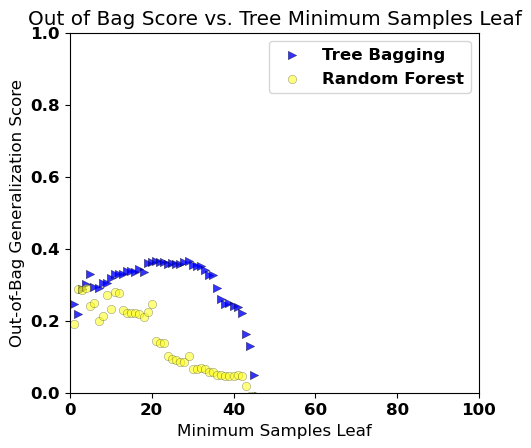

In [14]:
min_samples_leaf = np.linspace(1,100,100)
num_trees= 10
max_features=2

fit_bag=[]
oob_mse_bag=[]

fit_forest=[]
oob_mse_forest=[]


# The code below is extracted from Professor Michael Pyrcz workflows 

index = 1
print('Complete of ' + str(len(min_samples_leaf)) + ': ', end =" ")

for min_sample_leaf in min_samples_leaf:                                 # loop over number of trees in our random forest
    fit_bag.append(RandomForestRegressor(oob_score = True,min_samples_leaf=int(min_sample_leaf), random_state=13,n_estimators=num_trees, max_features=None))
    fit_bag[index-1].fit(X = X_train, y = y_train)

    fit_forest.append(RandomForestRegressor(oob_score = True,min_samples_leaf=int(min_sample_leaf), random_state=13,n_estimators=num_trees, max_features=max_features))
    fit_forest[index-1].fit(X = X_train, y = y_train)
    oob_mse_forest.append(fit_forest[index-1].oob_score_)
    oob_mse_bag.append(fit_bag[index-1].oob_score_)
    
    print(str(index)+ ', ', end =" ")
    index = index + 1
    
plt.subplot(121)
plt.scatter(min_samples_leaf,oob_mse_bag,s=None, c='blue', marker='>', cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black",label='Tree Bagging')
plt.scatter(min_samples_leaf,oob_mse_forest,s=None, c='yellow', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=0.5, linewidths=0.3, edgecolors="black",label='Random Forest')
plt.title('Out of Bag Score vs. Tree Minimum Samples Leaf'); plt.xlabel('Minimum Samples Leaf'); plt.ylabel('Out-of-Bag Generalization Score')
plt.xlim(0,100); plt.ylim(0,1.0)
plt.legend()

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

We have tuned the same hyperparameters for both models, let's now tune the max number of features in our random forest. By doing this we ensure that our random forest model it is the best possible.

Complete of 4:  1,  2,  3,  4,  

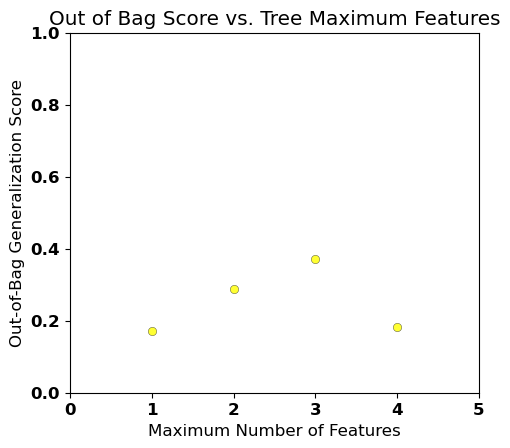

In [15]:
min_samples_leaf= 2
num_trees= 10
max_features=np.linspace(1,4,4)

fit_forest=[]
oob_mse_forest=[]

# The code below is extracted from Professor Michael Pyrcz workflows 

index = 1
print('Complete of ' + str(len(max_features)) + ': ', end =" ")

for max_feature in max_features:                                 # loop over number of trees in our random forest
    fit_forest.append(RandomForestRegressor(oob_score = True,min_samples_leaf=min_samples_leaf, random_state=13,n_estimators=num_trees, max_features=int(max_feature)))
    fit_forest[index-1].fit(X = X_train, y = y_train)
    oob_mse_forest.append(fit_forest[index-1].oob_score_)
    print(str(index)+ ', ', end =" ")
    index = index + 1

plt.subplot(121)
plt.scatter(max_features,oob_mse_forest,s=None, c='yellow', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Out of Bag Score vs. Tree Maximum Features'); plt.xlabel('Maximum Number of Features'); plt.ylabel('Out-of-Bag Generalization Score')
plt.xlim(0,5); plt.ylim(0,1.0)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Now, we can also use the Randomized Search CV function of Scikit Learn package to tune the hyperparameters of our models.

In [16]:
# Let's create our hyperparameter grid (random forest)
rf_grid = {'n_estimators': [10,20,30,40,50,100],
               'max_features': [1,2,3,4],
               'min_samples_leaf': [1,2,3,4,5,10,20,50]}

# Let's create our hyperparameter grid
tb_grid = {'n_estimators': [10,20,30,40,50,100],
           'max_features':[None],
           'min_samples_leaf': [1,2,3,4,5,10,20,50]}

hyperparameter_tuning(X_train,y_train,tb_grid,rf_grid)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
The best hyperparameters for Random forest are:{'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 100}
The best hyperparameters for Tree Bagging are:{'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 50}


Now that we have tuned our hyperparameters, let's build the models and test our hypothesis. We expect that our Random Forest model performs better than tree bagging

In [17]:
min_samples_leaf=1 #3
num_trees=40 #62

min_samples_leaf_rf=1
num_trees_rf=40
max_features_rf=2 #3

y_bag_pred,y_rf_pred=model_training(X_train,y_train,X_test,y_test,min_samples_leaf,min_samples_leaf_rf,num_trees,num_trees_rf,max_features_rf)

The MSE using Tree bagging is 722.982
The MSE using Random Forest is 655.048


Even though, we know that our model is a non linear problem, we can use R2 Score to get an idea of our model accuracy, it is preferably to use MSE for non linear models. 
* R2 Score: (coefficient of determination) regression score function

In [18]:
r2_bag=r2_score(y_test,y_bag_pred)
r2_rf=r2_score(y_test,y_rf_pred)

print(f'The R2 Score using Tree bagging is {round(r2_bag,3)}')
print(f'The R2 Score using Random Forest is {round(r2_rf,3)}')

The R2 Score using Tree bagging is 0.482
The R2 Score using Random Forest is 0.531


### Results
In the following cell, let's visualize our model performance comparing the mean squared error for tree bagging and random forest, as well as the true vs estimated response feature plot.

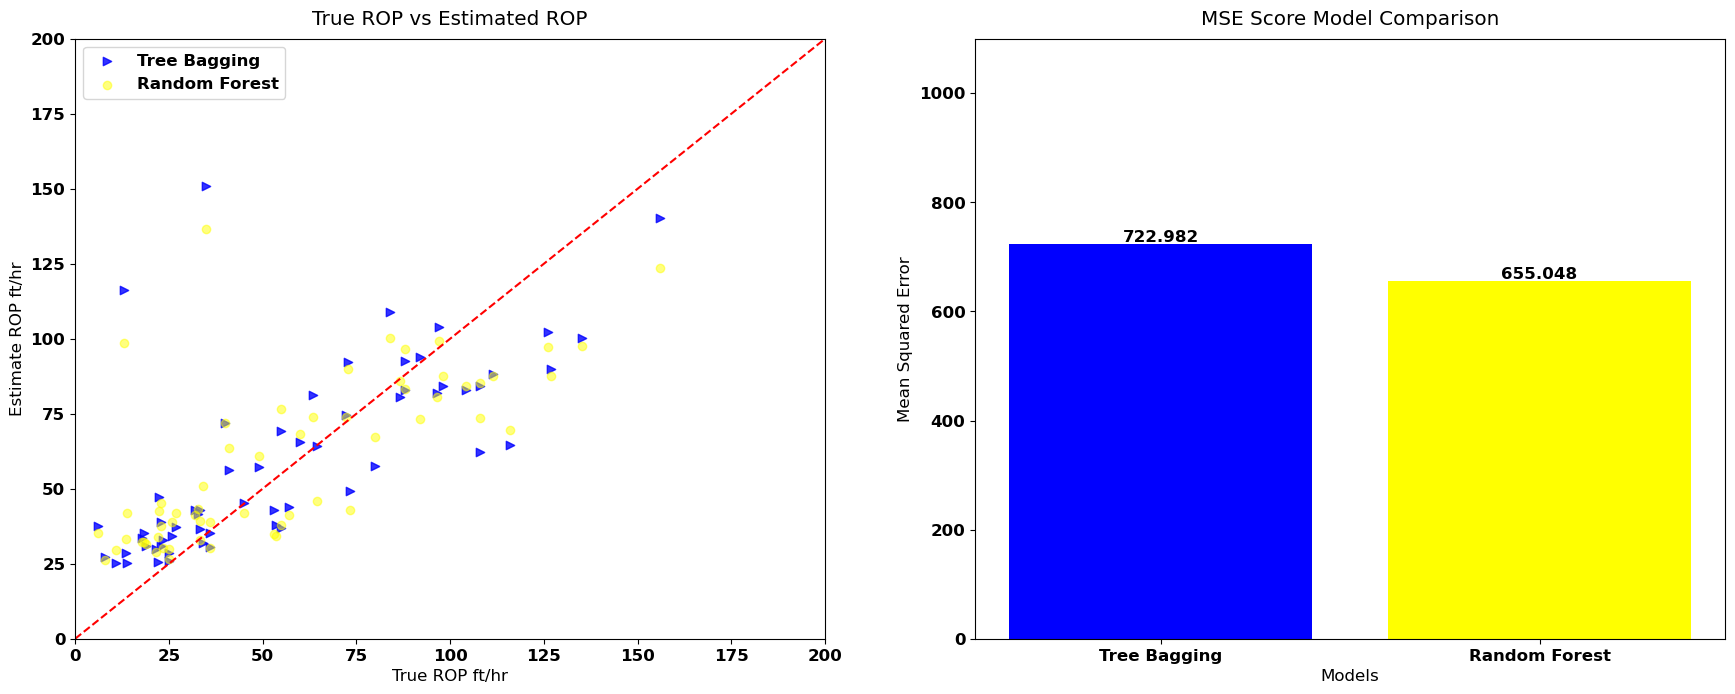

In [19]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(11,5),dpi=100)

ax1.scatter(y_test,y_bag_pred,label='Tree Bagging',alpha=0.8,c='blue',marker='>')
ax1.scatter(y_test,y_rf_pred,label='Random Forest',alpha=0.5,c='yellow',marker='o')
ax1.axline([0, 0], [1, 1],color='red',linestyle='--')

ax1.set_title('True ROP vs Estimated ROP',pad=10)
ax1.set_xlabel('True ROP ft/hr')
ax1.set_ylabel('Estimate ROP ft/hr')
ax1.set_xlim(0,200)
ax1.set_ylim(0,200)
ax1.legend()

mse_bag=mean_squared_error(y_test,y_bag_pred,multioutput='uniform_average')
mse_rf=mean_squared_error(y_test,y_rf_pred,multioutput='uniform_average')

bars=ax2.bar([1,2],[mse_bag,mse_rf],tick_label=['Tree Bagging','Random Forest'],color=['blue','yellow'])
ax2.set_title('MSE Score Model Comparison',pad=10)
ax2.set_ylim(0,1100)
ax2.set_xlabel('Models')
ax2.set_ylabel('Mean Squared Error')
ax2.bar_label(bars)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Our hypothesis was to prove that Random forest actually improves model accuracy, from our results we can tell that Random Forest performs better than tree bagging because it has less MSE. It is important to remark that in order to get this difference we needed to create sparsity in our data by removing random samples. 


I hope this was helpful,

*Jose*

**About me**

I am currently pursuing a Master's degree in Petroleum Engineering at The University of Texas at Austin. My current research topics are: *Carbon capture and Underground Storage* working for the Bureau of Economic Geology , Jackson School of Geosciences.

I am also interested in data analytics and machine learning solutions for the Oil & Gas Industry.

You can contact me at jubillus@utexas.edu or joseeduardou98@gmail.com

More about me, check out these links

#### [LinkedIn](https://www.linkedin.com/in/joseeduardoubillus/) | [GitHub](https://github.com/pizzio98)
___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
